# **Example IBIF | Impact factors for quantifying country-level terrestrial biodiversity intactness footprints**

**Authors:**
[Romain Sacchi](mailto:romain.sacchi@psi.ch)
[Alvaro Hahn Menacho](mailto:alvaro.hahn-menacho@psi.ch)

This notebook presents an example to obtain an exchange-based LCA score using the [Biodiversity impacts](https://doi.org/10.1038/s41597-025-05946-1) method developed by Schipper et al., 2025. The method is implemented in the `edges` package and can be used in `brightway2` and `brightway25` via the `EdgeLCIA` class.

The method, when used, should be cited as follows:

Schipper, A. M., van der Marel, M., Bakkenes, M., Giesen, P., van Oorschot, M. M., Wilting, H. C., ... & Marques, A. (2025). 
Impact factors for quantifying country-level terrestrial biodiversity intactness footprints (IBIF). Scientific Data, 12(1), 1660. https://doi.org/10.1038/s41597-025-05946-1


## Structure

1. [Import *edges* and set *bw2 project*](#sec_import_edges)
2. [Import hydrogen production, PEM, LCI](#sec_import_h2)
3. [Select *Functional Unit* and *method*](#sec_select_fu)
4. [Run edges based LCA](#sec_run_edges_lca)
5. [Export results](#sec_export_results)
6. [Plot results](#sec_plot_results)

<a id="sec_import_edges"></a>
# 1. Import the ``edges`` and set up a ``brightway`` project

In [1]:
import pandas as pd

from edges import EdgeLCIA, get_available_methods, setup_package_logging
import logging
import bw2data, bw2io

# we want the logger to log things into edges.log
setup_package_logging(level=logging.INFO)
# if you want full debug:
#setup_package_logging(level=logging.DEBUG)

15:01:01+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


/opt/homebrew/Caskroom/miniconda/base/envs/edges/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


For our example, we activate a ``brighway`` project that contains ecoinvent 3.10 cut-off.

In [2]:
bw2data.projects.set_current("bw25_ei310")
# bw2data.projects.set_current("ecoinvent-3.10-cutoff")

In [3]:
bw2data.databases

Databases dictionary with 4 object(s):
	biosphere
	ecoinvent-3.10.1-cutoff
	h2_pem
	test

<a id="sec_import_h2"></a>
# 2. Import hydrogen production, PEM, LCI

To illustrate our water footprint case, we need to import some inventories representing the production of hydrogen using a PEM electrolyzer, powered with offshore wind power in France. The inventories are provided in this repository (``lci-hydrogen-electrolysis-ei310.xlsx``).

In [4]:
if "h2_pem" in bw2data.databases:
    del bw2data.databases["h2_pem"]
lci = bw2io.ExcelImporter("lci-hydrogen-electrolysis-ei310.xlsx")
lci.apply_strategies()
lci.match_database(fields=["name", "reference product", "location"])
lci.match_database("ecoinvent-3.10.1-cutoff",fields=["name", "reference product", "location"])
lci.match_database("biosphere",fields=["name", "categories"])
lci.statistics()
lci.drop_unlinked(i_am_reckless=True)
if len(list(lci.unlinked)) == 0:
    lci.write_database()

# we assign manually classifications to activities
# since it is unclear how to do that in the Excel inventory file.

classifications = {
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from solar photovoltaic electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from onshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from geothermal electricity": ("CPC", "34210"),
    "electrolyzer production, 1MWe, PEM, Stack": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer stack, 1MWe, PEM": ("CPC", "3830"),
    "electrolyzer production, 1MWe, PEM, Balance of Plant": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer balance of plant, 1MWe, PEM": ("CPC", "3830"),
    "platinum group metal, extraction and refinery operations": ("CPC", "2420"),
    "deionized water production, via reverse osmosis, from brackish water": ("CPC", "34210")
}
for ds in bw2data.Database("h2_pem"):
    if ds["name"] in classifications:
        ds["classifications"] = [classifications[ds["name"]]]
        ds.save()


Extracted 1 worksheets in 0.02 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.05 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Graph statistics for `h2_pem` importer:
11 g

100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 1202.97it/s]

15:01:02+0200 [info     ] Vacuuming database            


Created database: h2_pem


<a id="sec_select_fu"></a>
# 3. Select Functional Unit and method

### 3.1. Select FU
We select the activity to run the LCA for. In our case, it is the production of 1 kg of hydrogen, using a PEM electrolyzer, powered with offshore wind power, in France.

In [5]:
act = [a for a in bw2data.Database("h2_pem") if a["name"] == "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity"][0]
act

'hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity' (kilogram, FR, None)

### 3.2. Select method

In [6]:
get_available_methods()

[('AWARE 2.0', 'Country', 'all', 'yearly'),
 ('AWARE 2.0', 'Country', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'non', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'unspecified', 'yearly'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'amphibians'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'birds'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'eukaryota'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'mammals'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'plants'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'reptiles'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'amphibians'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'birds'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'eukaryota'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'mammals'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'plants'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'reptiles'),
 ('GeoPol

In [7]:
methods = [
    ('IBIF', 'biodiversity', 'CO2', 'overall'),
 ('IBIF', 'biodiversity', 'CO2', 'plants'),
 ('IBIF', 'biodiversity', 'CO2', 'vert'),
 ('IBIF', 'biodiversity', 'LU', 'overall'),
 ('IBIF', 'biodiversity', 'LU', 'plants'),
 ('IBIF', 'biodiversity', 'LU', 'vert'),
 ('IBIF', 'biodiversity', 'NH3', 'overall'),
 ('IBIF', 'biodiversity', 'NH3', 'plants'),
 ('IBIF', 'biodiversity', 'NOx', 'overall'),
 ('IBIF', 'biodiversity', 'NOx', 'plants'),
 ('IBIF', 'biodiversity', 'all pressures', 'overall'),
 ('IBIF', 'biodiversity', 'all pressures', 'plants'),
 ('IBIF', 'biodiversity', 'all pressures', 'vert'),
]
methods

[('IBIF', 'biodiversity', 'CO2', 'overall'),
 ('IBIF', 'biodiversity', 'CO2', 'plants'),
 ('IBIF', 'biodiversity', 'CO2', 'vert'),
 ('IBIF', 'biodiversity', 'LU', 'overall'),
 ('IBIF', 'biodiversity', 'LU', 'plants'),
 ('IBIF', 'biodiversity', 'LU', 'vert'),
 ('IBIF', 'biodiversity', 'NH3', 'overall'),
 ('IBIF', 'biodiversity', 'NH3', 'plants'),
 ('IBIF', 'biodiversity', 'NOx', 'overall'),
 ('IBIF', 'biodiversity', 'NOx', 'plants'),
 ('IBIF', 'biodiversity', 'all pressures', 'overall'),
 ('IBIF', 'biodiversity', 'all pressures', 'plants'),
 ('IBIF', 'biodiversity', 'all pressures', 'vert')]

<a id="sec_run_edges_lca"></a>
# 4. Run edges-based LCA

In [8]:
import pandas as pd

main_df = pd.DataFrame()

for method in methods:
    print(f"--------------------")
    print(f"Processing: {method}")
    # we instantiate EdgeLCIA, which builds on the `bw2calc.LCA` class
    LCA = EdgeLCIA(
        demand={act: 1}, # <- we define a functional unit
        method=method, # <- we specify the LCIA method
        # use_distributions=True, # <- we want to consider variability across ecoregions
        # iterations=10000 # <- we specific the number of iterations
    )

    # apply strategies
    LCA.apply_strategies()
    LCA.evaluate_cfs()
    LCA.lcia()

    df = LCA.generate_cf_table()
    df["method"] = " ".join(method)
    main_df = pd.concat([main_df, df], ignore_index=True)

--------------------
Processing: ('IBIF', 'biodiversity', 'CO2', 'overall')


Processing global groups (pass 1): 100%|██████| 5/5 [00:00<00:00, 199728.76it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'CO2', 'plants')


Processing global groups (pass 1): 100%|██████| 5/5 [00:00<00:00, 216201.24it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'CO2', 'vert')


Processing global groups (pass 1): 100%|███████| 5/5 [00:00<00:00, 65128.94it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'LU', 'overall')


Processing global groups (pass 1): 100%|██████| 5/5 [00:00<00:00, 179243.76it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'LU', 'plants')


Processing global groups (pass 1): 100%|██████| 5/5 [00:00<00:00, 190650.18it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'LU', 'vert')


Processing global groups (pass 1): 100%|██████| 5/5 [00:00<00:00, 171897.70it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'NH3', 'overall')


Processing global groups (pass 1): 100%|███████| 1/1 [00:00<00:00, 49932.19it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'NH3', 'plants')


Processing global groups (pass 1): 100%|███████| 1/1 [00:00<00:00, 51781.53it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'NOx', 'overall')


Processing global groups (pass 1): 100%|███████| 1/1 [00:00<00:00, 40329.85it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'NOx', 'plants')


Processing global groups (pass 1): 100%|███████| 1/1 [00:00<00:00, 39568.91it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'all pressures', 'overall')


Processing global groups (pass 1): 100%|████| 12/12 [00:00<00:00, 387166.52it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'all pressures', 'plants')


Processing global groups (pass 1): 100%|████| 12/12 [00:00<00:00, 362098.19it/s]


--------------------
Processing: ('IBIF', 'biodiversity', 'all pressures', 'vert')


Processing global groups (pass 1): 100%|████| 10/10 [00:00<00:00, 322638.77it/s]


In [9]:
main_df.columns

Index(['supplier name', 'supplier categories', 'consumer name',
       'consumer reference product', 'consumer location', 'amount', 'CF',
       'impact', 'method'],
      dtype='object')

In [10]:
main_df["method"].unique()

array(['IBIF biodiversity CO2 overall', 'IBIF biodiversity CO2 plants',
       'IBIF biodiversity CO2 vert', 'IBIF biodiversity LU overall',
       'IBIF biodiversity LU plants', 'IBIF biodiversity LU vert',
       'IBIF biodiversity NH3 overall', 'IBIF biodiversity NH3 plants',
       'IBIF biodiversity NOx overall', 'IBIF biodiversity NOx plants',
       'IBIF biodiversity all pressures overall',
       'IBIF biodiversity all pressures plants',
       'IBIF biodiversity all pressures vert'], dtype=object)

In [11]:
main_df.head()

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact,method
0,"Carbon dioxide, fossil","(air, urban air close to ground)","natural gas, burned in gas turbine","natural gas, burned in gas turbine",DZ,9.842118e-05,3.900000e-07,3.838426e-11,IBIF biodiversity CO2 overall
1,"Carbon dioxide, fossil","(air, non-urban air or from high stacks)","natural gas production, liquefied","natural gas, liquefied",DZ,6.709250e-06,3.900000e-07,2.616607e-12,IBIF biodiversity CO2 overall
2,"Carbon dioxide, fossil","(air, non-urban air or from high stacks)","market for natural gas, high pressure","natural gas, high pressure",DZ,1.603699e-08,3.900000e-07,6.254426e-15,IBIF biodiversity CO2 overall
3,"Carbon dioxide, fossil","(air, non-urban air or from high stacks)","transport, pipeline, offshore, long distance, ...","transport, pipeline, offshore, long distance, ...",DZ,5.455580e-09,3.900000e-07,2.127676e-15,IBIF biodiversity CO2 overall
4,"Carbon dioxide, fossil","(air, non-urban air or from high stacks)","transport, pipeline, onshore, long distance, n...","transport, pipeline, onshore, long distance, n...",DZ,4.034118e-08,3.900000e-07,1.573306e-14,IBIF biodiversity CO2 overall


<a id="sec_plot_results"></a>
# 6. Plot results
Script used to produce Figure 2 in the Sacchi et al. 2025 article.


Pivot data for Plot 1:
species             overall        plants          vert
pressure                                               
CO2            6.301520e-07  7.626455e-07  4.992743e-07
LU             5.076888e-08  5.313764e-08  4.838594e-08
NH3            4.264888e-08  8.523205e-08           NaN
NOx            1.559270e-07  3.116128e-07           NaN
all pressures  8.731626e-07  1.200466e-06  5.475486e-07


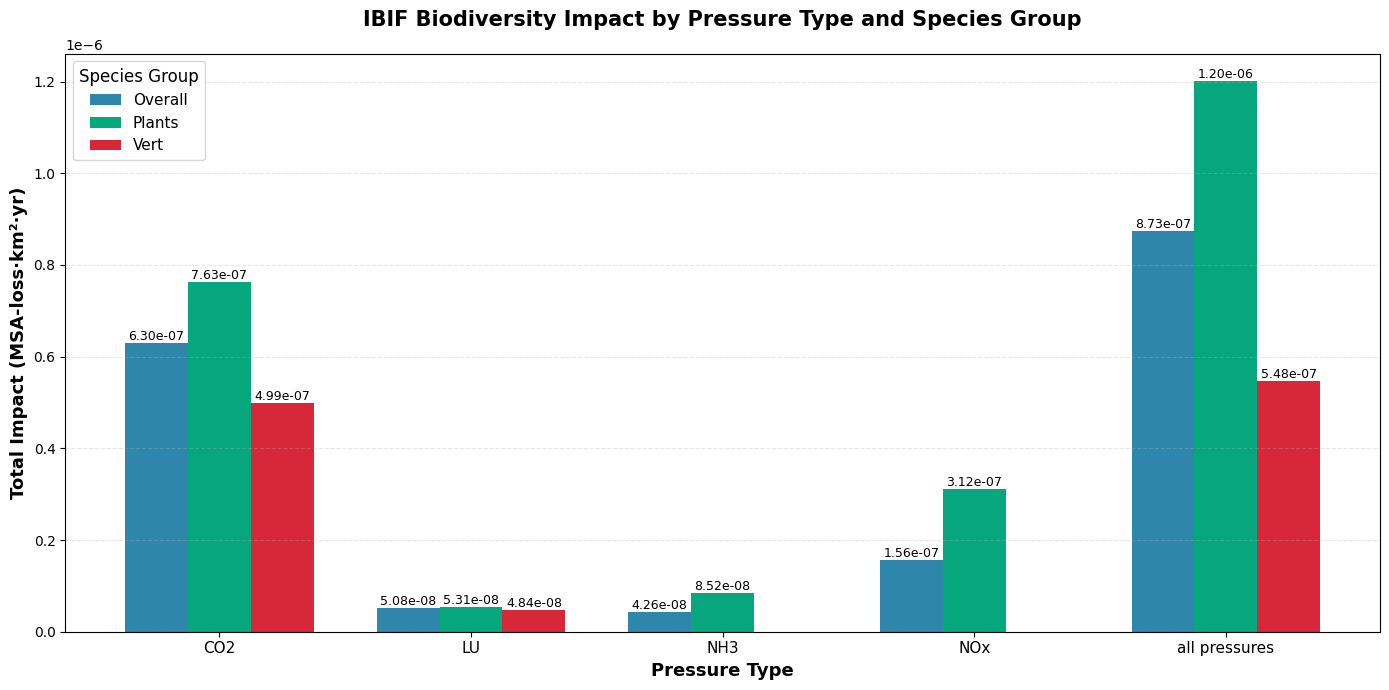


Top 10 consumer names:
1. electricity production, hard coal, conventional: 8.49e-07
2. blasting: 8.22e-07
3. electricity production, hard coal: 5.19e-07
4. nylon 6-6 production, glass-filled: 3.96e-07
5. clinker production: 2.45e-07
6. pig iron production: 2.08e-07
7. hard coal mine operation and hard coal preparation: 1.68e-07
8. heat production, at hard coal industrial furnace 1-10MW: 1.61e-07
9. diesel, burned in building machine: 1.39e-07
10. electricity production, lignite: 9.45e-08


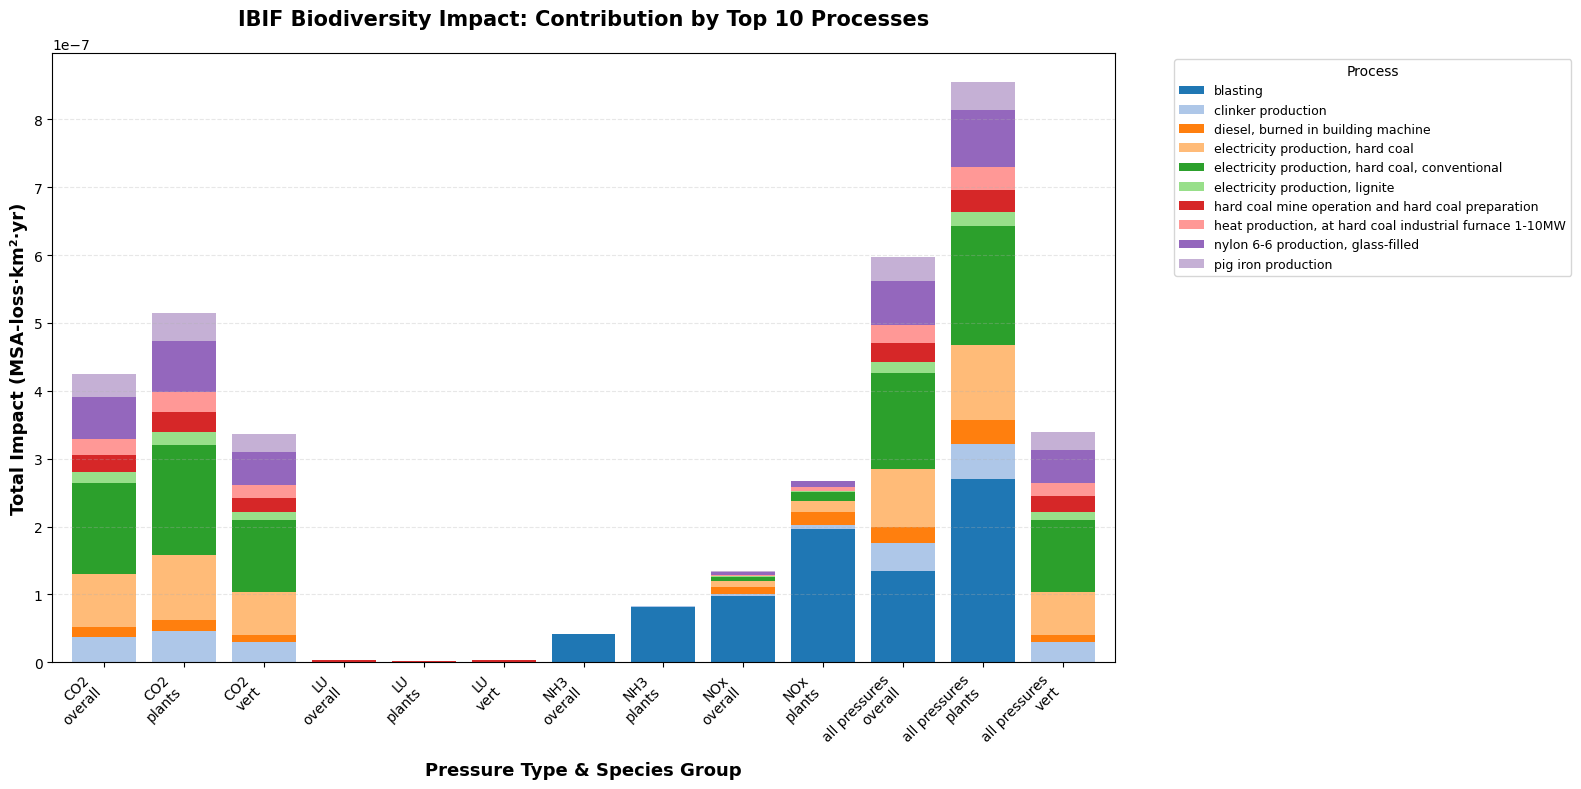


Top 10 consumer locations:
1. RoW: 2.13e-06
2. ZA: 9.74e-07
3. RER: 4.07e-07
4. GLO: 3.91e-07
5. CN: 2.36e-07
6. Europe without Switzerland: 6.06e-08
7. IN: 5.64e-08
8. RU: 5.60e-08
9. CN-NM: 4.49e-08
10. CN-SD: 3.42e-08


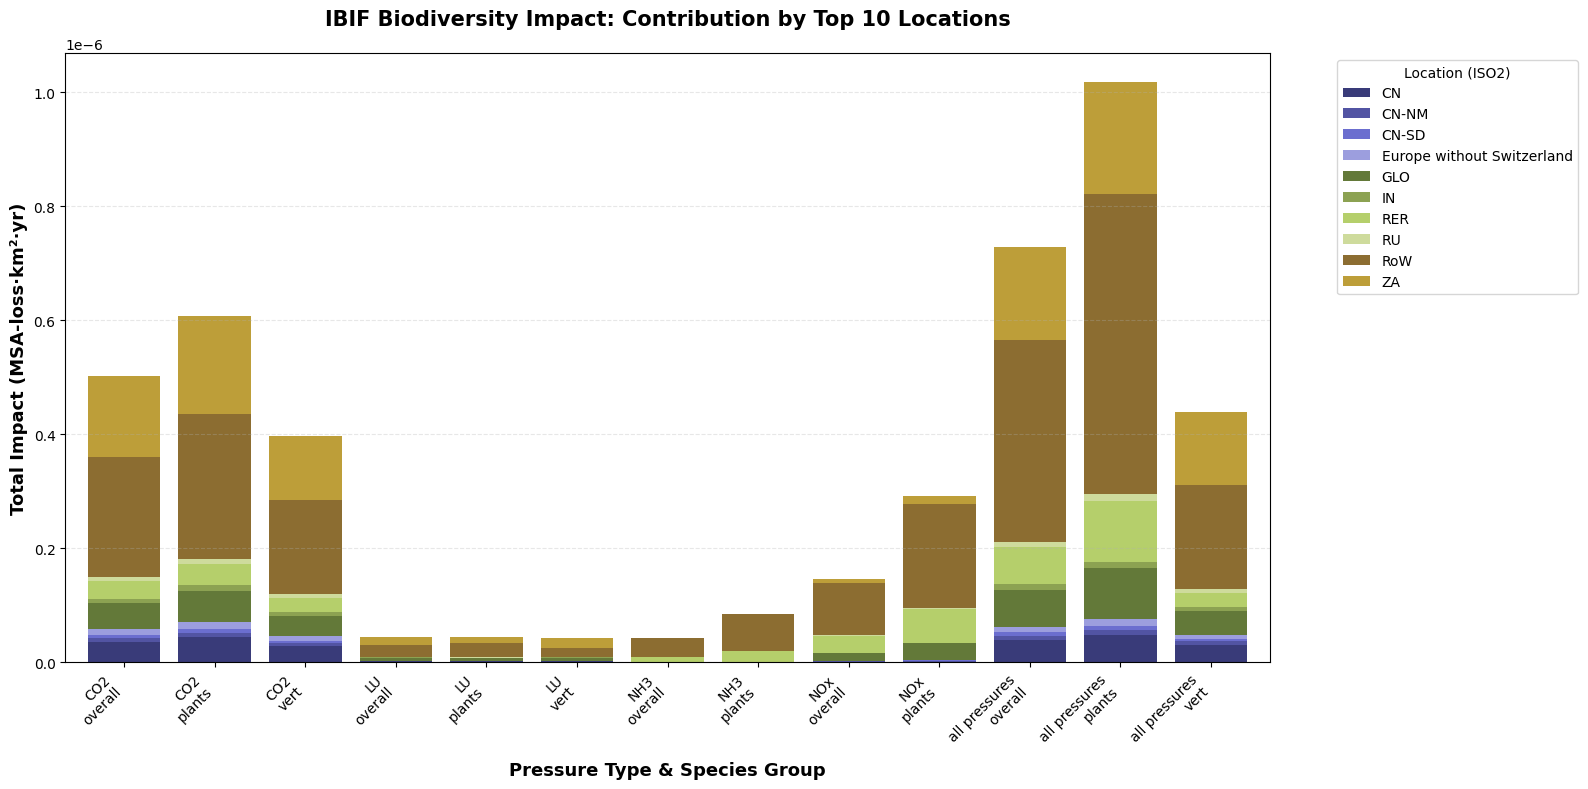

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# PLOT 1: Grouped bars showing total impact by method and species group
# ============================================================================

# Calculate total impact per method
method_totals = main_df.groupby('method')['impact'].sum().reset_index()

# Parse method names to extract pressure type and species group
method_totals['pressure'] = method_totals['method'].apply(
    lambda x: 'all pressures' if 'all pressures' in x else x.split('IBIF biodiversity ')[1].split()[0]
)
method_totals['species'] = method_totals['method'].str.extract(r'(overall|plants|vert)$')[0]

# Define order for pressures
pressure_order = ['CO2', 'LU', 'NH3', 'NOx', 'all pressures']
species_order = ['overall', 'plants', 'vert']

# Pivot to get the right structure
pivot_data = method_totals.pivot(index='pressure', columns='species', values='impact')
pivot_data = pivot_data.reindex(pressure_order)

print("\nPivot data for Plot 1:")
print(pivot_data)

# Create the grouped bar plot
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(pressure_order))
width = 0.25

colors = {'overall': '#2E86AB', 'plants': '#06A77D', 'vert': '#D62839'}

for i, species in enumerate(species_order):
    if species in pivot_data.columns:
        values = pivot_data[species].values
        # Replace NaN with 0 for plotting
        values = np.nan_to_num(values, nan=0.0)
        bars = ax.bar(x + i*width, values, width, label=species.capitalize(), color=colors[species])
        
        # Add value labels on top of bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2e}',
                       ha='center', va='bottom', fontsize=9, rotation=0)

ax.set_xlabel('Pressure Type', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Impact (MSA-loss·km²·yr)', fontsize=13, fontweight='bold')
ax.set_title('IBIF Biodiversity Impact by Pressure Type and Species Group', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x + width)
ax.set_xticklabels(pressure_order, fontsize=11)
ax.legend(title='Species Group', fontsize=11, title_fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Use scientific notation for y-axis
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()


# ============================================================================
# PLOT 2: Stacked bars showing top 10 consumer names
# ============================================================================

# Group by method and consumer name
consumer_impact = main_df.groupby(['method', 'consumer name'])['impact'].sum().reset_index()

# Parse method info
consumer_impact['pressure'] = consumer_impact['method'].apply(
    lambda x: 'all pressures' if 'all pressures' in x else x.split('IBIF biodiversity ')[1].split()[0]
)
consumer_impact['species'] = consumer_impact['method'].str.extract(r'(overall|plants|vert)$')[0]

# Create a combined category for grouping
consumer_impact['category'] = consumer_impact['pressure'] + '_' + consumer_impact['species']

# Get top 10 consumers overall
top_consumers = main_df.groupby('consumer name')['impact'].sum().nlargest(10).index.tolist()

print("\nTop 10 consumer names:")
for i, consumer in enumerate(top_consumers, 1):
    total = main_df[main_df['consumer name'] == consumer]['impact'].sum()
    print(f"{i}. {consumer}: {total:.2e}")

# Filter for top consumers
consumer_filtered = consumer_impact[consumer_impact['consumer name'].isin(top_consumers)].copy()

# Pivot data for stacking
pivot_consumers = consumer_filtered.pivot_table(
    index='category', 
    columns='consumer name', 
    values='impact', 
    fill_value=0
)

# Sort categories in desired order
category_order = []
for pressure in pressure_order:
    for species in species_order:
        cat = f"{pressure}_{species}"
        if cat in pivot_consumers.index:
            category_order.append(cat)

pivot_consumers = pivot_consumers.reindex(category_order)

# Create stacked bar plot
fig, ax = plt.subplots(figsize=(16, 8))

# Use a colormap for the consumers
cmap = plt.cm.tab20
colors_consumer = [cmap(i) for i in range(len(top_consumers))]

pivot_consumers.plot(kind='bar', stacked=True, ax=ax, color=colors_consumer, width=0.8)

# Customize x-axis labels
x_labels = [cat.replace('_', '\n') for cat in category_order]
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)

ax.set_xlabel('Pressure Type & Species Group', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Impact (MSA-loss·km²·yr)', fontsize=13, fontweight='bold')
ax.set_title('IBIF Biodiversity Impact: Contribution by Top 10 Processes', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(title='Process', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()


# ============================================================================
# PLOT 3: Stacked bars showing top 10 consumer locations
# ============================================================================

# Group by method and consumer location
location_impact = main_df.groupby(['method', 'consumer location'])['impact'].sum().reset_index()

# Parse method info
location_impact['pressure'] = location_impact['method'].apply(
    lambda x: 'all pressures' if 'all pressures' in x else x.split('IBIF biodiversity ')[1].split()[0]
)
location_impact['species'] = location_impact['method'].str.extract(r'(overall|plants|vert)$')[0]

# Create a combined category
location_impact['category'] = location_impact['pressure'] + '_' + location_impact['species']

# Get top 10 locations overall
top_locations = main_df.groupby('consumer location')['impact'].sum().nlargest(10).index.tolist()

print("\nTop 10 consumer locations:")
for i, location in enumerate(top_locations, 1):
    total = main_df[main_df['consumer location'] == location]['impact'].sum()
    print(f"{i}. {location}: {total:.2e}")

# Filter for top locations
location_filtered = location_impact[location_impact['consumer location'].isin(top_locations)].copy()

# Pivot data for stacking
pivot_locations = location_filtered.pivot_table(
    index='category', 
    columns='consumer location', 
    values='impact', 
    fill_value=0
)

# Sort categories
pivot_locations = pivot_locations.reindex(category_order)

# Create stacked bar plot
fig, ax = plt.subplots(figsize=(16, 8))

# Use a different colormap for locations
cmap_loc = plt.cm.tab20b
colors_location = [cmap_loc(i) for i in range(len(top_locations))]

pivot_locations.plot(kind='bar', stacked=True, ax=ax, color=colors_location, width=0.8)

# Customize x-axis labels
x_labels = [cat.replace('_', '\n') for cat in category_order]
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)

ax.set_xlabel('Pressure Type & Species Group', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Impact (MSA-loss·km²·yr)', fontsize=13, fontweight='bold')
ax.set_title('IBIF Biodiversity Impact: Contribution by Top 10 Locations', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(title='Location (ISO2)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()